## Load the dataset

In [1]:
import pandas as pd

df = pd.read_csv('../data/baq_dataset.csv')
df.head()

,time,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),snow_depth (m),weather_code (wmo code),...,carbon_monoxide (μg/m³),carbon_dioxide (ppm),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),methane (μg/m³),uv_index_clear_sky (),uv_index (),dust (μg/m³),aerosol_optical_depth ()
0,2022-08-04 00:00:00,26.1,93.0,25.0,32.2,0.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-04 01:00:00,26.3,92.0,24.9,32.1,0.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-04 02:00:00,26.7,90.0,24.9,32.3,0.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-04 03:00:00,26.3,92.0,24.9,31.7,0.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-04 04:00:00,25.9,94.0,24.8,31.5,0.0,0.0,0.0,0.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23312 entries, 0 to 23311
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   time                                23312 non-null  object 
 1   temperature_2m (°C)                 23160 non-null  float64
 2   relative_humidity_2m (%)            23160 non-null  float64
 3   dew_point_2m (°C)                   23160 non-null  float64
 4   apparent_temperature (°C)           23160 non-null  float64
 5   precipitation (mm)                  23160 non-null  float64
 6   rain (mm)                           23160 non-null  float64
 7   snowfall (cm)                       23160 non-null  float64
 8   snow_depth (m)                      22567 non-null  float64
 9   weather_code (wmo code)             23160 non-null  float64
 10  pressure_msl (hPa)                  23160 non-null  float64
 11  surface_pressure (hPa)              23160

## Preprocess the dataset

### Clean the dataset

In [3]:
def fill_missing_with_seasonal_median(df):
    df.index = pd.to_datetime(df.index)

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year

    feature_cols = df.columns.difference(['hour', 'day', 'month', 'year'])

    for col in feature_cols:
        missing_idx = df[df[col].isna()].index

        for idx in missing_idx:
            row = df.loc[idx]
            condition = (
                (df['month'] == row['month']) &
                (df['day'] == row['day']) &
                (df['hour'] == row['hour']) &
                (df['year'] != row['year']) &
                (~df[col].isna())
            )
            median_val = df.loc[condition, col].median()
            if pd.notna(median_val):
                df.at[idx, col] = median_val

    df.drop(columns=['hour', 'day', 'month', 'year'], inplace=True)
    return df

In [4]:
# Rename columns
df.columns = (
    df.columns
    .str.replace('\s*\(\)', '', regex=True)
    .str.replace(' ', '_', regex=False)
)

# Set index
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df.set_index('time', inplace=True)
df.sort_index(inplace=True)

# Drop columns
df.drop(columns=['carbon_dioxide_(ppm)', 'methane_(μg/m³)', 'snowfall_(cm)', 'snow_depth_(m)'], inplace=True)

# Perform linear interpolation
resampled_df = df.resample('1h').asfreq()
cleaned_df = resampled_df.interpolate(method='linear')

# Fill missing values
cleaned_df = fill_missing_with_seasonal_median(cleaned_df)

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/var/folders/9r/fhrqvdx56r5dsw2ynq0kc9mr0000gn/T/ipykernel_28175/3138282744.py:4: SyntaxWarning: invalid escape sequence '\s'
  .str.replace('\s*\(\)', '', regex=True)


### Perform feature engineering

In [5]:
def pm25_to_aqi_tier(pm25):
    if pm25 <= 12.0:
        return 0  # Good
    elif pm25 <= 35.4:
        return 1  # Moderate
    elif pm25 <= 55.4:
        return 2  # Unhealthy SG
    elif pm25 <= 150.4:
        return 3  # Unhealthy
    elif pm25 <= 250.4:
        return 4  # Very Unhealthy
    else:
        return 5  # Hazardous

In [6]:
import numpy as np

# Time-based features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['is_night'] = df['hour'].apply(lambda h: 1 if (h < 6 or h >= 20) else 0)
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Lag features
lags = [1, 3, 6, 12, 24]
for lag in lags:
    for col in ['pm2_5_(μg/m³)', 'pm10_(μg/m³)', 'ozone_(μg/m³)', 'dust_(μg/m³)']:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Rolling features
windows = [3, 6, 12]
for window in windows:
    for col in ['pm2_5_(μg/m³)', 'pm10_(μg/m³)', 'ozone_(μg/m³)']:
        df[f'{col}_rollmean{window}'] = df[col].rolling(window=window).mean()

# Air quality index tier
df['pm2_5_tier'] = df['pm2_5_(μg/m³)'].apply(pm25_to_aqi_tier)

Drop null from feature engineering

In [7]:
df.dropna(inplace=True)

### Split the dataset

In [8]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

total_size = len(cleaned_df)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)

train_df = cleaned_df[:train_size].copy()
val_df = cleaned_df[train_size:train_size + val_size].copy()
test_df = cleaned_df[train_size + val_size:].copy()

### Normalize the dataset

In [9]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

feature_cols = [col for col in cleaned_df.columns if col != 'pm2_5_(μg/m³)']
target_col = 'pm2_5_(μg/m³)'

feature_scaler.fit(train_df[feature_cols])
target_scaler.fit(train_df[[target_col]])

train_df.loc[:, feature_cols] = feature_scaler.transform(train_df[feature_cols])
val_df.loc[:, feature_cols] = feature_scaler.transform(val_df[feature_cols])
test_df.loc[:, feature_cols] = feature_scaler.transform(test_df[feature_cols])

train_df.loc[:, [target_col]] = target_scaler.transform(train_df[[target_col]])
val_df.loc[:, [target_col]] = target_scaler.transform(val_df[[target_col]])
test_df.loc[:, [target_col]] = target_scaler.transform(test_df[[target_col]])

### Create the sequences

In [10]:
import numpy as np

def create_sequences(data, target_column, sequence_length, forecast_horizon):
    X, y = [], []
    feature_data = data.drop(target_column, axis=1).values
    target_data = data[target_column].values

    for i in range(len(data) - sequence_length - forecast_horizon + 1):
        X.append(feature_data[i:i + sequence_length])
        y.append(target_data[i + sequence_length : i + sequence_length + forecast_horizon])

    return np.array(X), np.array(y)


In [11]:
sequence_length = 24 * 7
forecast_horizon = 24

X_train, y_train = create_sequences(train_df, target_col, sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_df, target_col, sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_df, target_col, sequence_length, forecast_horizon)

print("Train Set:", X_train.shape, y_train.shape)
print("Val Set:  ", X_val.shape, y_val.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set: (16127, 168, 37) (16127, 24)
Val Set:   (2140, 168, 37) (2140, 24)
Test Set:  (4472, 168, 37) (4472, 24)


## Build an LSTM model

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# === Model Architecture ===
def encoder_decoder_lstm(input_shape, forecast_horizon):
    encoder_inputs = Input(shape=input_shape)

    # Encoder: LSTM(128)
    _, state_h, state_c = LSTM(128, return_state=True)(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder: LSTM must have same units = 128
    decoder_input = RepeatVector(forecast_horizon)(state_h)
    decoder_output = LSTM(128, return_sequences=True)(decoder_input, initial_state=encoder_states)
    decoder_output = Dropout(0.2)(decoder_output)

    decoder_output = TimeDistributed(Dense(1))(decoder_output)

    model = Model(encoder_inputs, decoder_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


# === Callbacks ===
def create_callbacks():
    checkpoint_callback = ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
    reduce_lr_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=0.000001,
        mode='min',
        verbose=1
    )
    return [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

# === Evaluation ===
def evaluate(model, target_scaler, X_test, y_test):
    y_pred = model.predict(X_test)

    if target_scaler is not None:
        y_pred_inv = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
        y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
    else:
        y_pred_inv = y_pred
        y_test_inv = y_test

    forecast_horizon = y_pred.shape[1]
    for step in range(forecast_horizon):
        rmse = np.sqrt(mean_squared_error(y_test_inv[:, step], y_pred_inv[:, step]))
        mae = mean_absolute_error(y_test_inv[:, step], y_pred_inv[:, step])
        r2 = r2_score(y_test_inv[:, step], y_pred_inv[:, step])
        print(f"[t+{step+1}] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.4f}")

    plt.figure(figsize=(20, 5))
    plt.plot(y_test_inv[:100, 0], label='True t+1')
    plt.plot(y_pred_inv[:100, 0], label='Pred t+1')
    plt.plot(y_test_inv[:100, -1], label=f'True t+{forecast_horizon}')
    plt.plot(y_pred_inv[:100, -1], label=f'Pred t+{forecast_horizon}')
    plt.legend()
    plt.grid()
    plt.title("Predictions for t+1 and t+{}".format(forecast_horizon))
    plt.show()


In [23]:
y_train_seq = y_train[..., np.newaxis]  # shape: (16127, 24, 1)
y_val_seq   = y_val[..., np.newaxis]    # shape: (2140, 24, 1)
y_test_seq  = y_test[..., np.newaxis]   # shape: (4472, 24, 1)

forecast_horizon = 24
model = encoder_decoder_lstm(input_shape=X_train.shape[1:], forecast_horizon=forecast_horizon)

history = model.fit(
    X_train, y_train_seq,
    validation_data=(X_val, y_val_seq),
    epochs=100,
    batch_size=32,
    shuffle=False,
    callbacks=create_callbacks(),
    verbose=1
)

Epoch 1/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0129 - mae: 0.0775
Epoch 1: val_loss improved from inf to 0.00038, saving model to best_model.keras
504/504 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - loss: 0.0129 - mae: 0.0775 - val_loss: 3.8050e-04 - val_mae: 0.0151 - learning_rate: 0.0010
Epoch 2/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0083 - mae: 0.0589
Epoch 2: val_loss did not improve from 0.00038
504/504 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - loss: 0.0083 - mae: 0.0589 - val_loss: 4.3443e-04 - val_mae: 0.0165 - learning_rate: 0.0010
Epoch 3/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0080 - mae: 0.0570
Epoch 3: val_loss did not improve from 0.00038
504/504 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - loss: 0.0080 - mae: 0.0570 - val_loss: 4.8406e-04 - val_mae: 0.0177 - learning_rate: 0.0010
Epoch 4/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0075 - mae: 0.0551
Epoch 4: val_loss did not improve from 0.00038
504/504 ━━━━━━━━━━━━━━━━━━━━ 40s 80

In [50]:
model.save('../models/lstm_model_2.h5')

## Evaluate the model

140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
[t+1] RMSE: 19.55, MAE: 15.31, R2: 0.2807
[t+2] RMSE: 22.30, MAE: 17.51, R2: 0.0634
[t+3] RMSE: 23.98, MAE: 18.63, R2: -0.0824
[t+4] RMSE: 25.01, MAE: 19.15, R2: -0.1773
[t+5] RMSE: 25.74, MAE: 19.47, R2: -0.2477
[t+6] RMSE: 26.32, MAE: 19.75, R2: -0.3043
[t+7] RMSE: 26.78, MAE: 20.01, R2: -0.3502
[t+8] RMSE: 27.14, MAE: 20.24, R2: -0.3862
[t+9] RMSE: 27.39, MAE: 20.45, R2: -0.4129
[t+10] RMSE: 27.58, MAE: 20.62, R2: -0.4320
[t+11] RMSE: 27.71, MAE: 20.76, R2: -0.4460
[t+12] RMSE: 27.81, MAE: 20.86, R2: -0.4571
[t+13] RMSE: 27.89, MAE: 20.94, R2: -0.4671
[t+14] RMSE: 27.94, MAE: 21.00, R2: -0.4768
[t+15] RMSE: 27.97, MAE: 21.05, R2: -0.4863
[t+16] RMSE: 27.97, MAE: 21.10, R2: -0.4949
[t+17] RMSE: 27.96, MAE: 21.14, R2: -0.5021
[t+18] RMSE: 27.96, MAE: 21.20, R2: -0.5078
[t+19] RMSE: 27.99, MAE: 21.26, R2: -0.5128
[t+20] RMSE: 28.02, MAE: 21.33, R2: -0.5185
[t+21] RMSE: 28.08, MAE: 21.39, R2: -0.5261
[t+22] RMSE: 28.18, MAE: 21.47, R2: -0.5368
[

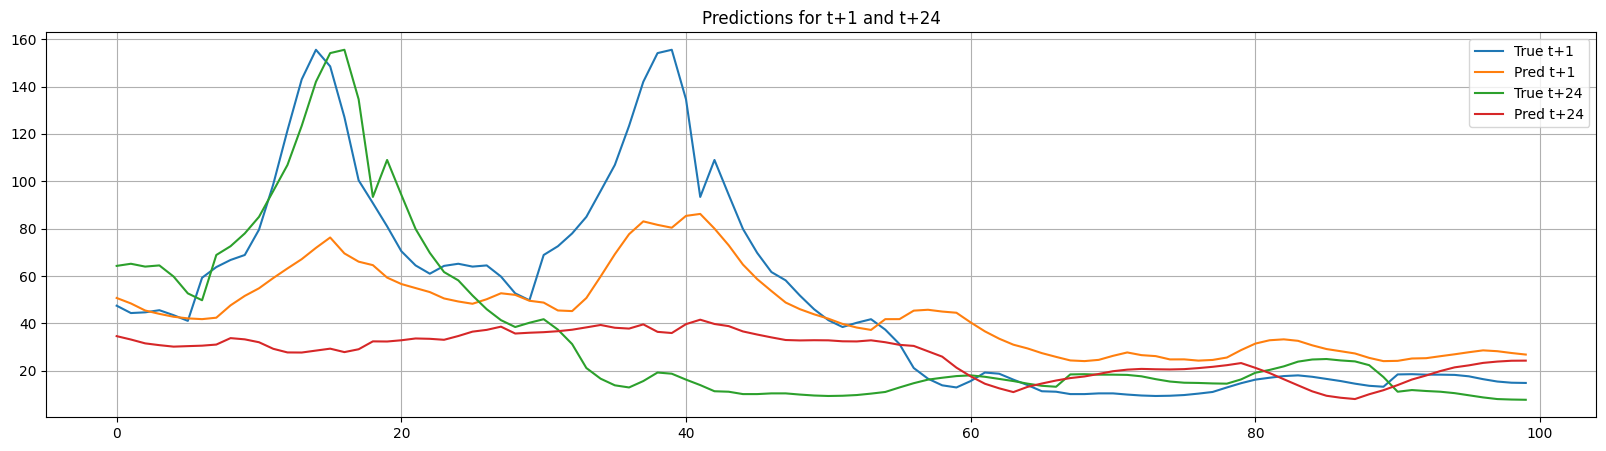

In [24]:
evaluate(model, target_scaler, X_test, y_test)

## Compare the models

In [51]:
from tensorflow.keras.models import load_model

lstm = load_model('../models/lstm_model_2.h5', compile=False)
lstm.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 24, 128)        │        84,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,465 (525.25 KB)

 Trainable params: 134,465 (525.25 KB)

 Non-trainable params: 0 (0.00 B)

145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error (MSE)               52.9810
Root Mean Squared Error (RMSE)         7.2788
Mean Absolute Error (MAE)              5.3259
Mean Absolute Percentage Error (MAPE)  18.7063 [Accuracy ~81.2937%]
R-squared (R2)                         0.9020


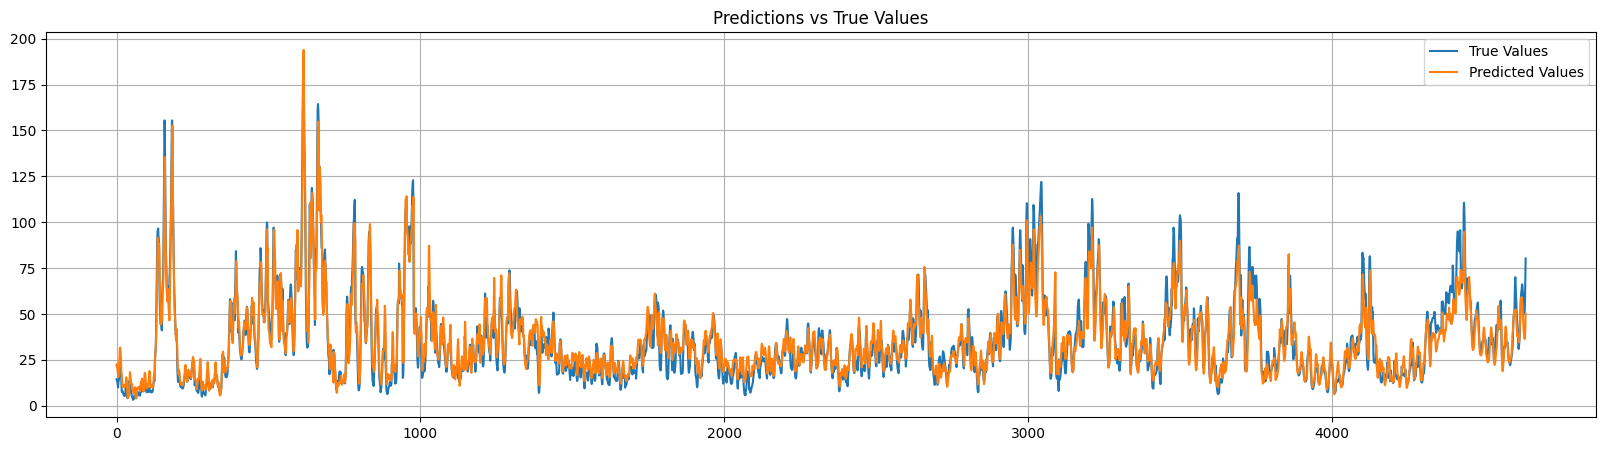

In [52]:
evaluate(lstm, target_scaler, X_test, y_test)